# Task 2 Clustering
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*
## Importing Libraries
First we import the libraries necessary to cluster the data

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from prettytable import PrettyTable
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform

In [13]:
df = pd.read_csv("../dataset/user_indicators.csv")
df.head(10)

,user_id,lang,bot,created_at,statuses_count,tweet_count,avg_text_len,retweet_count_avg,reply_count_avg,favorite_count_avg,num_hashtags_avg,num_urls_avg,num_mentions_avg,retweet_count_sum,favorite_count_sum
0,2353593986,en,True,2019-02-22 18:00:42,76,127,62.378788,0.037879,0.000000,0.037879,0.098485,0.000000,0.272727,5,5
1,2358850842,en,False,2019-02-26 03:02:32,54,119,68.762295,0.024590,0.000000,0.049180,0.024590,0.000000,0.336066,3,6
2,137959629,en,True,2015-04-30 07:09:56,3,4,19.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
3,466124818,it,True,2017-01-18 02:49:18,50,1394,86.763030,0.826963,0.000000,0.166782,0.073662,0.022238,0.006254,1190,240
4,2571493866,en,False,2019-06-18 19:30:21,7085,3535,72.214442,0.016958,0.000000,0.056072,0.117888,0.000821,0.505470,62,205
5,2199062688,en,False,2018-11-19 06:58:18,7406,1989,45.100913,393.697261,0.000000,0.735704,0.024027,0.022585,0.928400,819284,1531
6,1174869769,en,True,2018-02-15 10:51:28,21,24,64.041667,630.166667,0.000000,94.666667,0.458333,0.125000,0.125000,15124,2272
7,3118659848,en,False,2020-03-31 21:19:59,115,130,62.400000,3090.303704,0.000000,0.925926,0.111111,0.088889,0.807407,417191,125
8,616225564,en,False,2017-06-25 15:49:36,2041,58,66.883333,69.850000,0.016667,0.050000,0.233333,0.033333,0.016667,4191,3
9,2357425536,en,True,2019-02-25 04:30:56,69,144,64.286667,0.040000,0.000000,0.033333,0.100000,0.000000,0.340000,6,5


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             11508 non-null  int64  
 1   lang                11508 non-null  object 
 2   bot                 11508 non-null  bool   
 3   created_at          11508 non-null  object 
 4   statuses_count      11508 non-null  int64  
 5   tweet_count         11508 non-null  int64  
 6   avg_text_len        11508 non-null  float64
 7   retweet_count_avg   11508 non-null  float64
 8   reply_count_avg     11508 non-null  float64
 9   favorite_count_avg  11508 non-null  float64
 10  num_hashtags_avg    11508 non-null  float64
 11  num_urls_avg        11508 non-null  float64
 12  num_mentions_avg    11508 non-null  float64
 13  retweet_count_sum   11508 non-null  int64  
 14  favorite_count_sum  11508 non-null  int64  
dtypes: bool(1), float64(7), int64(5), object(2)
memory us

In [15]:
cat_feature = df[['user_id', 'lang', 'created_at']]
del df['user_id']
del df['lang']
del df['created_at']
del df['bot']
df.head()

,statuses_count,tweet_count,avg_text_len,retweet_count_avg,reply_count_avg,favorite_count_avg,num_hashtags_avg,num_urls_avg,num_mentions_avg,retweet_count_sum,favorite_count_sum
0,76,127,62.378788,0.037879,0.0,0.037879,0.098485,0.000000,0.272727,5,5
1,54,119,68.762295,0.024590,0.0,0.049180,0.024590,0.000000,0.336066,3,6
2,3,4,19.250000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0
3,50,1394,86.763030,0.826963,0.0,0.166782,0.073662,0.022238,0.006254,1190,240
4,7085,3535,72.214442,0.016958,0.0,0.056072,0.117888,0.000821,0.505470,62,205


## Clustering Preprocessing - Normalization  
A good practice in clustering to avoid the bias given by the range of the different attribute is normalization.  
The most common adopted normalizations are: Z-Score and Min-Max

In [16]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df.values)
X_std

array([[-0.30258956, -0.66364966, -0.34704183, ..., -0.2293346 ,
        -0.17600845, -0.07752062],
       [-0.30376279, -0.67015003,  0.04770931, ..., -0.05664378,
        -0.1760091 , -0.07748064],
       [-0.30648253, -0.76359287, -3.0140927 , ..., -0.97292096,
        -0.17601008, -0.07772051],
       ...,
       [-0.30632254, -0.76115523,  0.25676065, ...,  0.19557188,
        -0.17601008, -0.07772051],
       [-0.30440273, -0.68477587, -0.32452807, ...,  0.01380633,
        -0.17600779, -0.07740068],
       [-0.0251226 ,  2.11607153, -0.98720074, ...,  1.19040404,
         0.48220648, -0.06028945]])

In [17]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(df.values)
X_minmax

array([[1.90211610e-04, 3.21510589e-02, 2.45366892e-01, ...,
        4.64618484e-02, 4.96593715e-08, 5.40565085e-06],
       [1.35150355e-04, 3.01097219e-02, 2.71745021e-01, ...,
        5.72521684e-02, 2.97956229e-08, 6.48678102e-06],
       [7.50835304e-06, 7.65501403e-04, 6.71487603e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.50167061e-05, 1.53100281e-03, 2.85714286e-01, ...,
        7.30114761e-02, 0.00000000e+00, 0.00000000e+00],
       [1.05116943e-04, 2.55167134e-02, 2.46871311e-01, ...,
        6.16541353e-02, 6.95231201e-08, 8.64904136e-06],
       [1.32121986e-02, 9.05077826e-01, 2.02590084e-01, ...,
        1.35172032e-01, 2.00273564e-02, 4.71372754e-04]])

## K-MEANS

For K-Means we use

Best results without entropies obtained using **minmax scaler**

In [18]:
def KMeansFunction (X, n_clusters_list, n_init_value, max_iter_value=300):
    kmeans_list = list()

    for numCluster in tqdm(n_clusters_list):

        kmeans = KMeans(n_clusters=numCluster, n_init=n_init_value, max_iter=max_iter_value)
        kmeans.fit(X)
        kmeans_list.append(kmeans)
    
    return kmeans_list

In [36]:
clusters_list = [x for x in range(1, 31)]
init_value = 10
iter_value = 300

kmeans_list = KMeansFunction (X_minmax, clusters_list, init_value, iter_value)

sse_list = []
silhouette_list = []
for i, kmeans in enumerate(kmeans_list):
    sse_list.append(kmeans.inertia_)
    try:
        silhouette = silhouette_score(X_minmax, kmeans.labels_)
    except:
        silhouette = np.nan # silhouette returns exception when there is only 1 label
    silhouette_list.append(silhouette)

    print('K:', clusters_list[i], ' - SSE:', kmeans.inertia_, '- SILHOUETTE:', silhouette)


100%|██████████| 30/30 [00:41<00:00,  1.40s/it]


K: 1  - SSE: 1312.752078323833 - SILHOUETTE: nan
K: 2  - SSE: 380.22874165317205 - SILHOUETTE: 0.6768948380985009
K: 3  - SSE: 209.90063980684494 - SILHOUETTE: 0.6637726026529703
K: 4  - SSE: 181.8584228172617 - SILHOUETTE: 0.610024976410328
K: 5  - SSE: 162.52658574430197 - SILHOUETTE: 0.5674766541257461
K: 6  - SSE: 148.95483453978468 - SILHOUETTE: 0.5577737819849892
K: 7  - SSE: 137.60846225445098 - SILHOUETTE: 0.5434075806439342
K: 8  - SSE: 128.9781134447045 - SILHOUETTE: 0.5523860036715093
K: 9  - SSE: 119.59374794170606 - SILHOUETTE: 0.5495080723262444
K: 10  - SSE: 113.11932138181744 - SILHOUETTE: 0.355854332042706
K: 11  - SSE: 105.94293357355956 - SILHOUETTE: 0.5524575136487407
K: 12  - SSE: 99.68121642378169 - SILHOUETTE: 0.3630393965422243
K: 13  - SSE: 94.12175161021777 - SILHOUETTE: 0.5539710780921174
K: 14  - SSE: 88.84384650214821 - SILHOUETTE: 0.3730224129640013
K: 15  - SSE: 84.75888498561106 - SILHOUETTE: 0.37356814954657114
K: 16  - SSE: 79.85969786504567 - SILHOUET

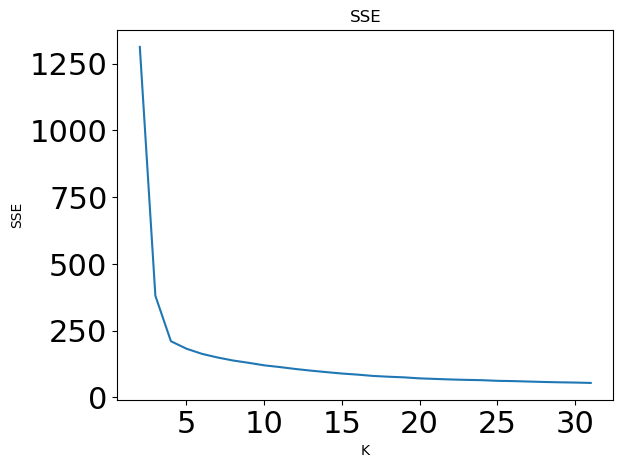

In [39]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SSE')
plt.show()

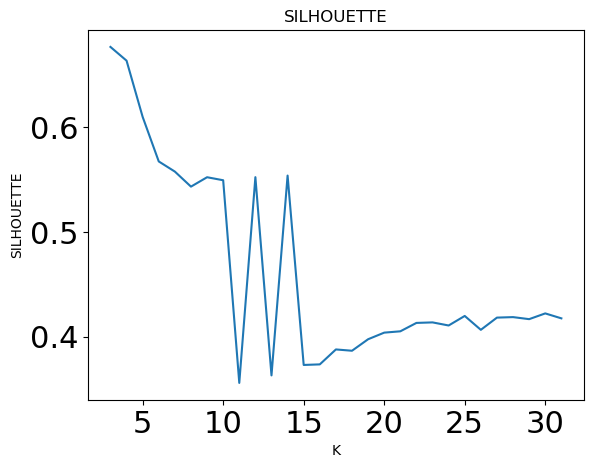

In [40]:
plt.plot(range(2, len(silhouette_list) + 2), silhouette_list)
plt.ylabel('SILHOUETTE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SILHOUETTE')
plt.show()

Scegliere k adeguato

scatter con plot adeguato

distribuzioni plot per ogni cluster (utilizzando label bot)

# DBSCAN

Function that shows graph of knn diastance in in order to use Knee Method to estimate the best eps

In [53]:
def calc_k_nn_dist_graph(X):
    k_list = [3, 4, 5 , 6]

    dist = pdist(X, 'euclidean') #pair wise distance
    dist = squareform(dist) #distance matrix given the vector dist

    for k in k_list:
        kth_distances = list()
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])

        plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
        plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
        plt.xlabel('sorted distances', fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=22)
        f = plt.figure()
        f.set_figwidth(4)
        f.set_figheight(1)
        plt.show()

In [22]:
def db_scan_function (X, eps_list, minpts_list, max_iter_value=300):
    dbscan_table = list()

    for i, eps in tqdm(enumerate(eps_list)):
        dbscan_table.append([]) 

        for minpts in tqdm(minpts_list, leave=False):
            dbscan = DBSCAN(eps=eps, min_samples=minpts, n_jobs=-1)
            dbscan.fit(X)
            dbscan_table[i].append(dbscan)
    
    return dbscan_table

DBSCAN with **minmax scaler**

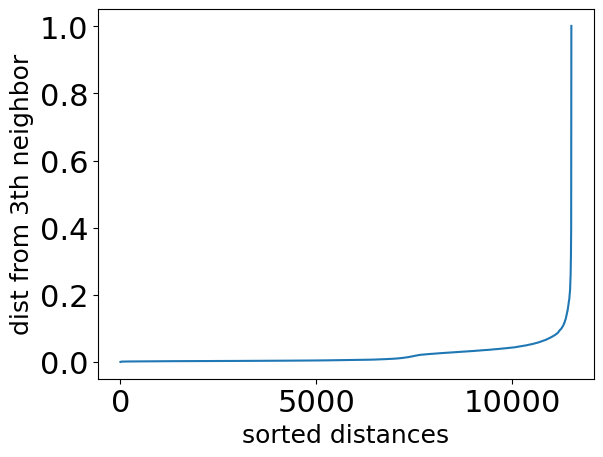

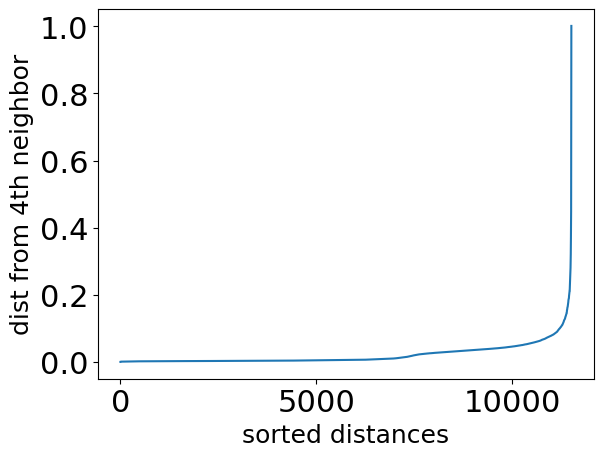

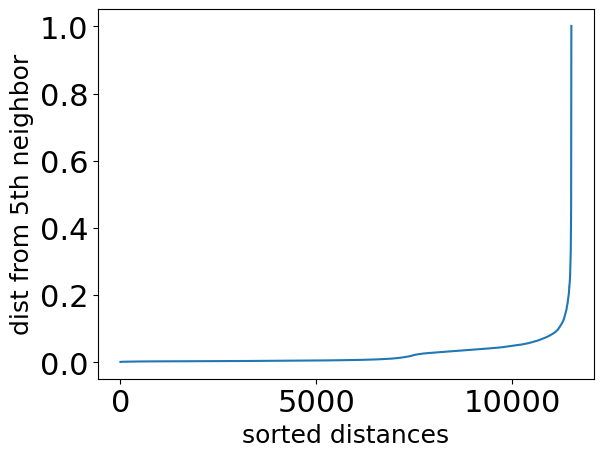

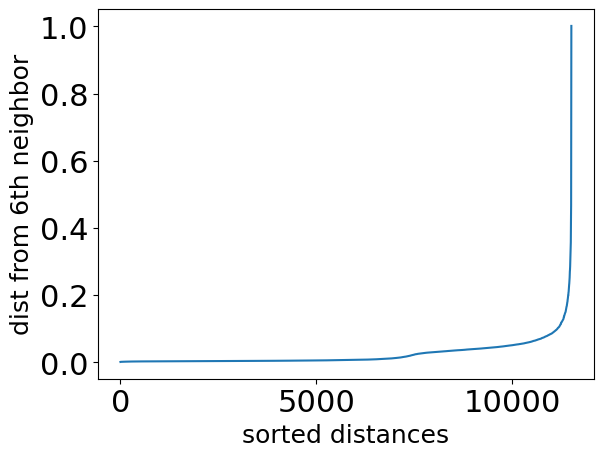

In [47]:
calc_k_nn_dist_graph(X_minmax)

We select values for eps around 0.08-0.2

In [48]:
eps_list = [0.08, 0.1, 0.15, 0.2] # min max vals
minpts_list = [2, 3, 4, 5] # min-max

dbscan_table = db_scan_function(X_minmax, eps_list, minpts_list)

4it [00:44, 11.21s/it]


In [49]:
silhouette_list = np.zeros((len(eps_list), len(minpts_list)))
t = PrettyTable()
t.field_names = ['eps\minpts'] + minpts_list

for i, eps in tqdm(enumerate(eps_list)):
    row_str = [str(eps)]
    for j, minpts  in tqdm(enumerate(minpts_list), leave=False):
        dbscan = dbscan_table[i][j]

        try:
            silhouette = round(silhouette_score(X_minmax, dbscan.labels_), 2)
        except:
            silhouette = np.nan
        silhouette_list[i][j] = silhouette
        cell_str = str(silhouette) + '-n_clust:'+str(len(np.unique(dbscan.labels_))-1)
        row_str.append(cell_str)

    t.add_row(row_str)

print(t)

4it [01:30, 22.52s/it]

+------------+------------------+------------------+----------------+-----------------+
| eps\minpts |        2         |        3         |       4        |        5        |
+------------+------------------+------------------+----------------+-----------------+
|    0.08    | -0.34-n_clust:39 | -0.02-n_clust:14 | 0.0-n_clust:8  | -0.01-n_clust:3 |
|    0.1     | -0.32-n_clust:28 | 0.01-n_clust:10  | 0.15-n_clust:6 |  0.19-n_clust:5 |
|    0.15    | 0.04-n_clust:15  |  0.12-n_clust:7  | 0.41-n_clust:5 |  0.43-n_clust:3 |
|    0.2     |  0.35-n_clust:6  |  0.35-n_clust:5  | 0.58-n_clust:3 |  0.58-n_clust:3 |
+------------+------------------+------------------+----------------+-----------------+


DBSCAN with **standard scaler**

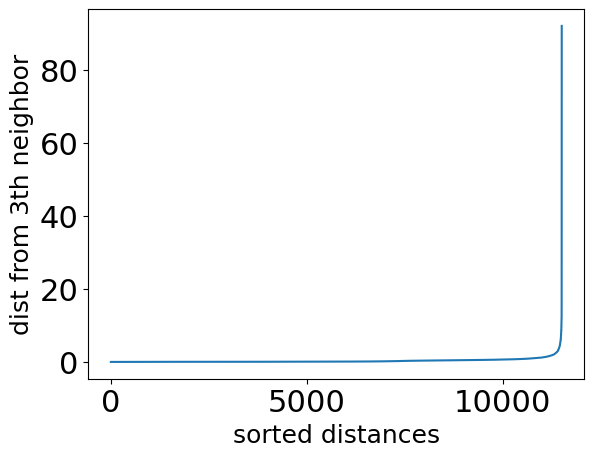

<Figure size 400x100 with 0 Axes>

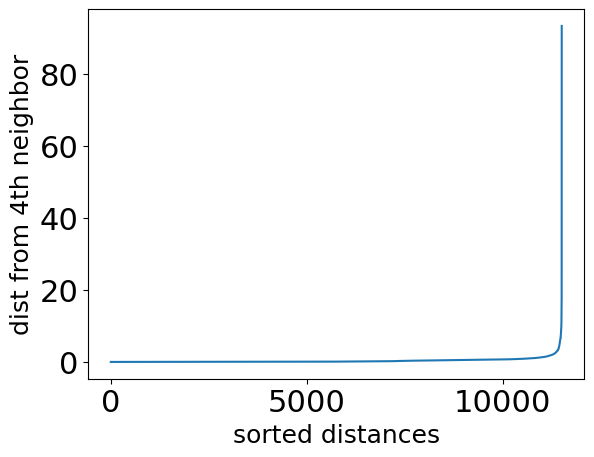

<Figure size 400x100 with 0 Axes>

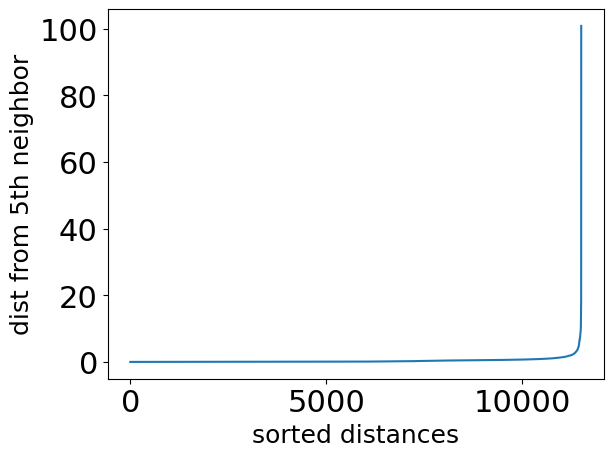

<Figure size 400x100 with 0 Axes>

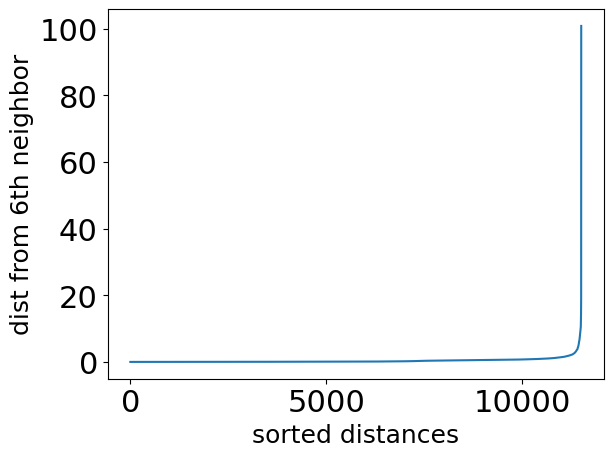

<Figure size 400x100 with 0 Axes>

In [55]:
calc_k_nn_dist_graph(X_std)

TODO: migliora grafico knn distances (cutoff a 20,  grid o yticks).
According to the Knee Method, we experimented with eps values in the range 1-3.

In [34]:
eps_list = [1, 1.25, 1.5, 2, 2.5, 3] 
minpts_list = [3, 4, 5, 6] 

dbscan_table = db_scan_function(X_std, eps_list, minpts_list)

6it [01:40, 16.82s/it]


In [35]:
silhouette_arr = np.zeros((len(eps_list), len(minpts_list)))
t = PrettyTable()
t.field_names = ['eps\minpts'] + minpts_list


for i, eps in enumerate(eps_list):
    row_str = [str(eps)]
    for j, minpts  in enumerate(minpts_list):
        dbscan = dbscan_table[i][j]

        try:
            silhouette = round(silhouette_score(X_std, dbscan.labels_), 2)
        except:
            silhouette = np.nan
        silhouette_arr[i][j] = silhouette
        cell_str = str(silhouette) + '-n_clust:'+str(len(np.unique(dbscan.labels_))-1)
        row_str.append(cell_str)
        #print('eps:', eps, 'minpts:', minpts ,' - Silhouette:', silhouette)
        #print('unique labels:', np.unique(dbscan.labels_))
    t.add_row(row_str)

print(t)

+------------+-----------------+-----------------+----------------+----------------+
| eps\minpts |        3        |        4        |       5        |       6        |
+------------+-----------------+-----------------+----------------+----------------+
|     1      | 0.18-n_clust:18 | 0.21-n_clust:10 | 0.43-n_clust:4 | 0.55-n_clust:3 |
|    1.25    | 0.21-n_clust:16 |  0.26-n_clust:7 | 0.49-n_clust:3 | 0.55-n_clust:4 |
|    1.5     | 0.31-n_clust:10 |  0.32-n_clust:7 | 0.3-n_clust:2  | 0.56-n_clust:2 |
|     2      | 0.59-n_clust:10 |  0.59-n_clust:6 | 0.82-n_clust:1 | 0.81-n_clust:1 |
|    2.5     |  0.65-n_clust:8 |  0.7-n_clust:4  | 0.81-n_clust:3 | 0.84-n_clust:2 |
|     3      |  0.7-n_clust:7  |  0.7-n_clust:6  | 0.7-n_clust:5  | 0.71-n_clust:3 |
+------------+-----------------+-----------------+----------------+----------------+


Scegliere dbscan adeguato

scatter con plot adeguato

distribuzioni plot per ogni cluster (utilizzando label bot)

# Hierarchical